In [101]:
import pandas as pd
import numpy as np
import yaml
import pycountry
import pycountry_convert as pc
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
data_swissre = pd.read_csv('./data/final_data.csv', parse_dates=['date']).set_index('date')

# Selecting columns for the first model

In [103]:
with open('config/r_estim_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)

In [104]:
columns_to_use= swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['economic'] +\
            swissre_features['vaccines'] +\
            swissre_features['policies'] +\
            swissre_features['outcome'] 

outcome = 'epiforecasts_effective_reproduction_number_median' # r_estim epiforecasts_effective_reproduction_number_median

In [105]:
df = data_swissre[columns_to_use].copy()

### Vaccines: shifting them 10 days below

In [69]:
for country in df.iso_code.unique():
    temp = df[df['iso_code'] == country][['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations', 'vaccination_policy']]
    temp = temp.shift(periods=14, fill_value=0)
    df.loc[df['iso_code'] == country,['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated', 'daily_vaccinations', 'vaccination_policy']] = temp

### Normal workflow

In [106]:
# Taking the data starting from the 1st of april. ALTERNATIVE: use days since outbreak
df = df[df.index >= '2020-04-01'].sort_index() #

In [107]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

df = filter_valid_countries(df, 0.9)

In [108]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 168


In [109]:
# Putting NaN where the estimated reproduction number is larger than 4
df[outcome] = np.where(df[outcome] >= 4, np.nan, df[outcome])

In [110]:
# Shifting the reproduction rate by 11 days for each country
df['date_index'] = df.index
df = df.sort_values(by = ['iso_code', 'date_index'])
df['shifted_r_estim'] = df[outcome]

In [111]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 162


# Training the first model

In [112]:
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot

In [114]:
final_iso_code = 'FRA'

# Final training colums
train_cols= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['vaccines'] +\
            swissre_features['economic'] +\
            swissre_features['policies'] 

final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]

In [115]:
list(set(train_cols) - set(final_train_cols))

[]

In [116]:
context = Context()

Global seed set to 42


In [117]:
pipeline = Pipeline(df, final_train_cols, 'shifted_r_estim', final_iso_code, 7, context) #shifted_r_estim
pipeline.fit_pipeline(save_model=False)

Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 4.3 K 
1 | linear_1 | Linear | 2.4 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) 

........................................................

In [118]:
predictions = pipeline.predict()

plot = Plot(df, 'shifted_r_estim', final_iso_code, save_path='./plots/')

The mean average error was 0.015381934347318117


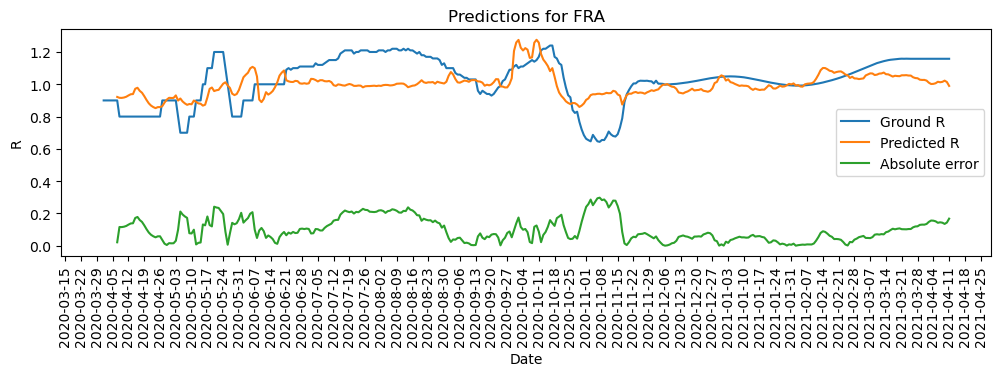

In [119]:
plot.plot_results(predictions, show = True)

invalid value encountered in true_divide
invalid value encountered in true_divide
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


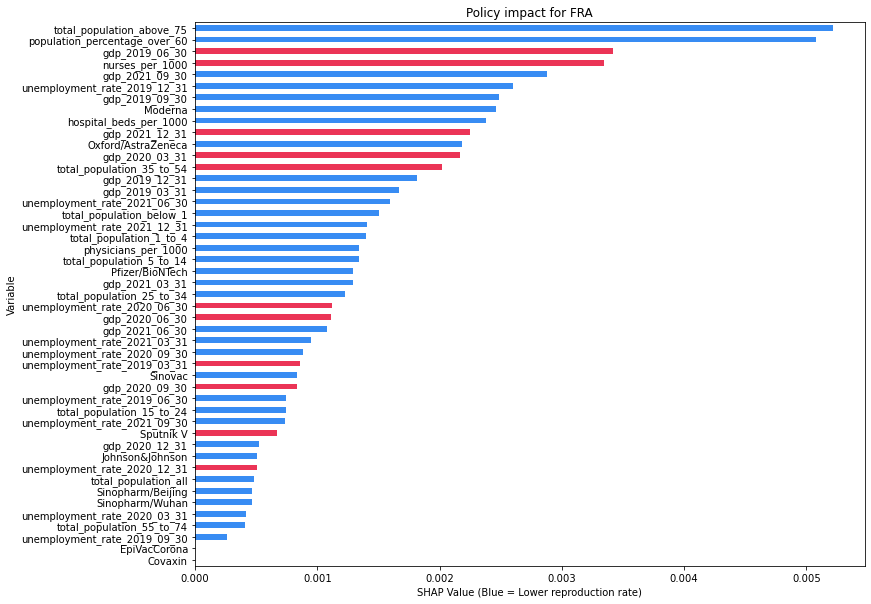

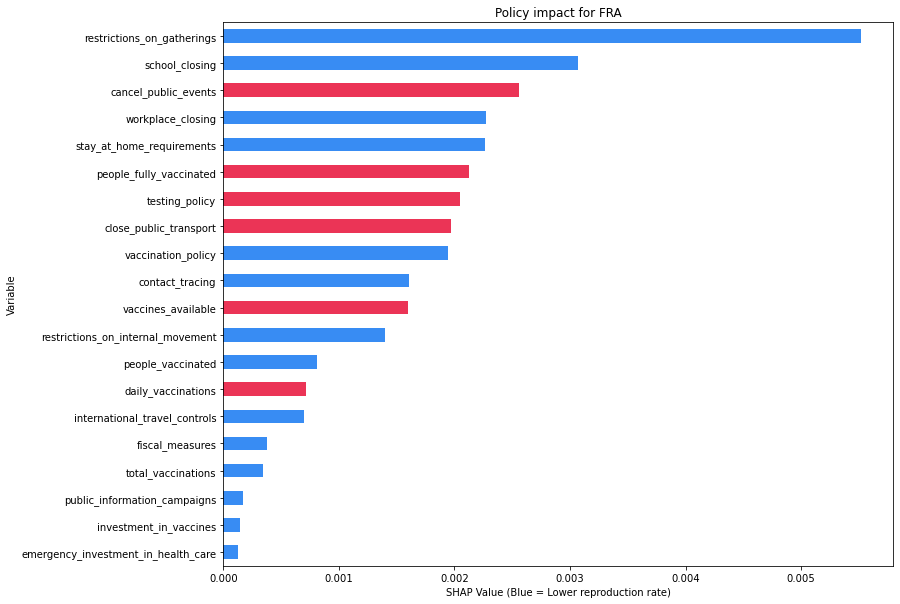

In [120]:
# Plotting shap
train, val = pipeline.get_data()

const_cols, var_cols = pipeline.get_cols()
plot.plot_shap(pipeline.get_model(), const_cols, var_cols, train, val, plot_bars=True, cols_to_drop = swissre_features['weather'])